# Calibrating the flats

Recall that the counts in an astronomical image include dark current, noise, and
a near-constant offset, the bias. The individual flat frames need to have bias
and dark removed from them. Depending on the exposure times of the images you
have, you may or may not need to subtract dark and bias separately.

If the combined dark frame needs to be scaled to a different exposure time, then
bias and dark must be handled separately; otherwise, the dark and bias can be
removed in a single step because dark frames also include bias.

The potential reduction steps for flat frames are below:

+ Subtract overscan and trim, if necessary.
+ Subtract bias, if necessary.
+ Subtract dark current, scaling if necessary (scale down when possible).

As in the chapters about bias and dark we will work through two examples. In
Example 1 the darks are not scaled and the overscan region is used as part of
the calibration. In Example 2 the darks are scaled and the overscan region is
trimmed off without being used.

## Function definition

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R34){:target="_blank"}

The function below finds the nearest dark exposure time to the exposure time of
a given image. An exception is raised if the difference in exposure time is
larger than `tolerance`, unless `tolerance` is set to `None`. A small numerical
tolerance is most useful if you anticipate not scaling the dark frames and
finding a dark exposure time close to the time of the image. Disregarding the
tolerance is useful if the intent is to scale the dark frames anyway.

In [1]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.
    
    Parameters
    ----------
    
    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.
    
    dark_exposure_times : list
        Exposure times for which there are darks.
    
    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.
    
    Returns
    -------
    
    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and 
        np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):
        
        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, a_flat.header['exptime']))
        
    
    return closest_dark_exposure

In [2]:
from pathlib import Path

from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdp
from matplotlib import pyplot as plt
import numpy as np

from convenience_functions import show_image

In [3]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

## Example 1: No scaling of dark frames

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R120){:target="_blank"}

The images for this example are from chip 0 of the Large Format Camera at
Palomar Observatory. The raw images are at XXX, and this notebook assumes that
you have worked through the notebooks on bias and dark so that there is a folder
called `example1-reduced` in the same folder as this notebook.

We'll go through this example twice: once with a single image to explain each
step, and then again to process all of the flat frames in the directory of raw data.

An image collection is defined below, along with a couple of settings useful for
this example.

In [4]:
reduced_path = Path('example1-reduced')

ifc_reduced = ccdp.ImageFileCollection(reduced_path)

combined_dark_files = ifc_reduced.files_filtered(imagetyp='dark', combined=True)

flat_image_type = 'FLATFIELD'

The raw data should be in the directory `example-cryo-LFC`.

In [5]:
raw_data = Path('example-cryo-LFC')

ifc_raw = ccdp.ImageFileCollection(raw_data)

The cell below checks that the files needed are available.

In [6]:
n_combined_dark = len(combined_dark_files)
expected_exposure_times = set([7, 70, 300])

if n_combined_dark < 3:
    raise RuntimeError('One or more combined dark is missing. Please re-run the dark notebook.')
elif n_combined_dark > 3:
    raise RuntimeError('There are more combined dark frames than expected.')
    
actual_exposure_times = set(h['exptime'] for h in ifc_reduced.headers(imagetyp='dark', combined=True))

if (expected_exposure_times - actual_exposure_times):
    raise RuntimeError('Encountered unexpected exposure time in combined darks. '
                       'The unexpected times are {}'.format(actual_exposure_times - expected_exposure_times))

First, get one of the flat frames as a `CCDData` object and display it.

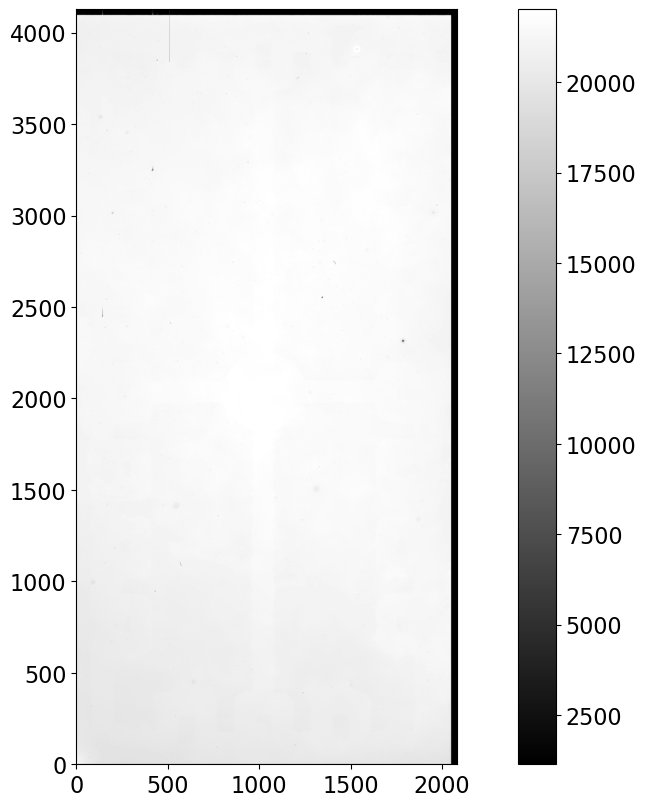

In [7]:
a_flat = CCDData.read(ifc_raw.files_filtered(imagetyp='flatfield', include_path=True)[0], unit='adu')

show_image(a_flat, cmap='gray')

There is not a lot of variation in this. Note that the overscan region on the
right stands out as a black bar, and there is apparently also an overscan
region across the top of the chip. There appears to be a slight variation in
pixel values from the bottom to the top of the image.

### Subtract overscan and trim, if necessary

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R227){:target="_blank"}

The overscan is useful for the LFC and needs to be subtracted and trimmed off.
See [this example in the dark reduction notebook](03-05-Calibrate-dark-images.html#Decide-which-calibration--steps-to-take) for a review of the overscan parameters.
The overscan region is the Python slice `[:, 2055:]` while the region to be
retained after trimming is the Python slice `[:, :2048]`.

Text(0.5, 1.0, 'Single flat frame, overscan subtracted and trimmed')

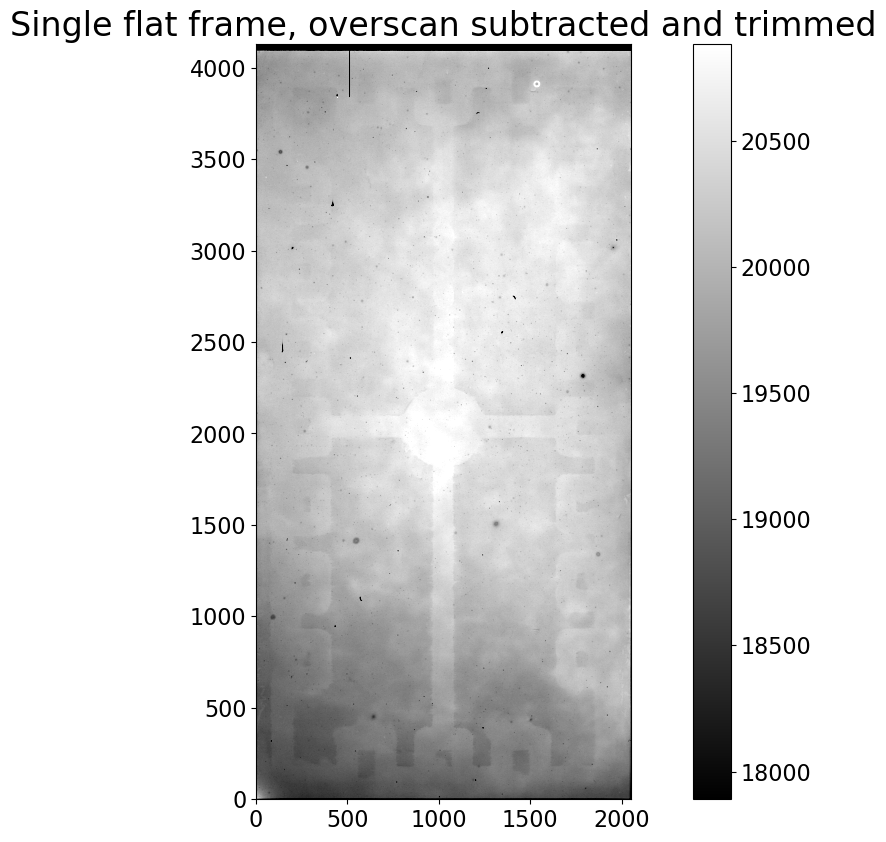

In [8]:
# Subtract the overscan
a_flat_reduced = ccdp.subtract_overscan(a_flat, overscan=a_flat[:, 2055:], median=True)

# Trim the overscan
a_flat_reduced = ccdp.trim_image(a_flat_reduced[:, :2048])

# Display the result so far
show_image(a_flat_reduced, cmap='gray')
plt.title('Single flat frame, overscan subtracted and trimmed')

Trimming off the overscan makes such a big difference primarily because the
image stretch changed; the lowest pixel values are now around 18000 instead of 
2000. With that change, the nonuniformity across the detector is much clearer.

### Subtracting bias is not necessary in this example

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R265){:target="_blank"}

For this particular set of images there are darks with exposure time 7, 70, and
300 sec. The flat images have the exposure times listed below:

In [9]:
set(ifc_raw.summary['exptime'][ifc_raw.summary['imagetyp'] == 'FLATFIELD'])

{7.0, 70.001, 70.011}

These are close enough to the exposure time of the dark frames that there is no
need to scale the darks by exposure time. If the darks are not going to be
scaled then there is no need to subtract the bias.

### Subtract dark current, no scaling necessary in this example

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R293){:target="_blank"}

We need to subtract the dark without scaling it. Rather than manually figuring
out which dark to subtract, we use the dark frame closest in exposure time to the
flat, within a tolerance of 1 second to ensure that we do not end up using a
dark *too* far off in exposure time from the flat.

First, find the dark exposure time closest to the flat. We will need to do this
again later in the notebook, so we define a function to do it.

In [10]:
closest_dark = find_nearest_dark_exposure(a_flat_reduced, actual_exposure_times)

It will be convenient to be able to access the darks via a dictionary whose key
is the exposure time, so we set that up below.

In [11]:
combined_darks = {ccd.header['exptime']: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}

Next, we subtract the dark from the flat and display the result.

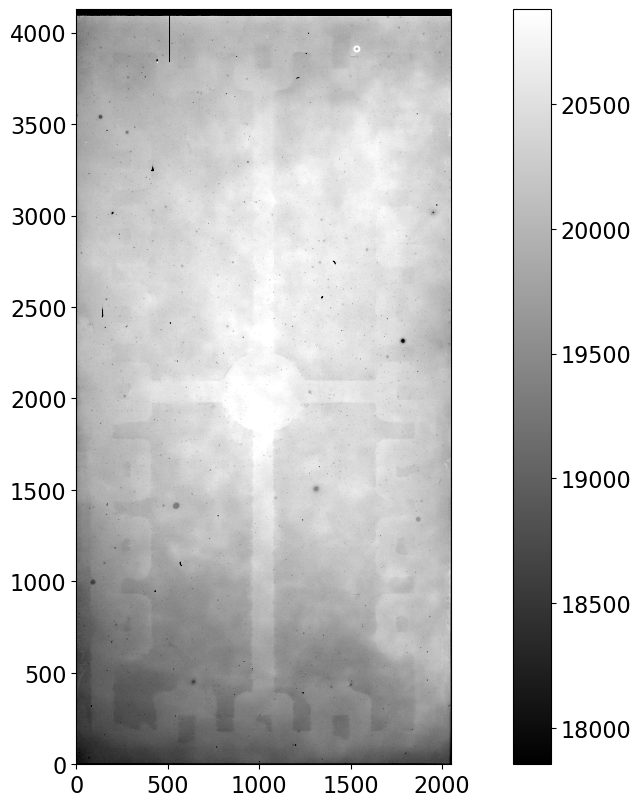

In [12]:
a_flat_reduced = ccdp.subtract_dark(a_flat_reduced, combined_darks[closest_dark], 
                                    exposure_time='exptime', exposure_unit=u.second, scale=False)
show_image(a_flat_reduced, cmap='gray')

There is not much change here; that is not surprising since the dark current in
this camera is low.

### Calibrate all of the flats in the folder

The cell below calibrates each of the flats in the folder, automatically
grabbing the correct combined dark for each flat.

In [13]:
for ccd, file_name in ifc_raw.ccds(imagetyp='FLATFIELD',            # Just get the bias frames
                                         ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                                     # it is not in the header
                                         return_fname=True           # Provide the file name too.
                                        ):    
    # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:, 2055:], median=True)
    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :2048])
    
    # Find the correct dark exposure
    closest_dark = find_nearest_dark_exposure(ccd, actual_exposure_times)
    
    # Subtract the dark current 
    ccd = ccdp.subtract_dark(ccd, combined_darks[closest_dark],
                             exposure_time='exptime', exposure_unit=u.second)

    # Save the result; there are some duplicate file names so pre-pend "flat"
    ccd.write(reduced_path / ('flat-' + file_name))

## Example 2: Dark frames are scaled

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R403){:target="_blank"}

The images in this example, like in the previous notebooks, is a
thermoelectrically-cooled CCD described in more detail in the
[overscan notebook](01-08-Overscan.html#Case-2:-Thermo-electrically-cooled-Apogee-Aspen-CG16M).

We'll go through this example twice: once with a single image to explain each
step, and then again to process all of the flat frames in the directory of raw data.

An image collection is defined below, along with a couple of settings useful for
this example.

In [14]:
reduced_path = Path('example2-reduced')

ifc_reduced = ccdp.ImageFileCollection(reduced_path)

combined_dark_files = ifc_reduced.files_filtered(imagetyp='dark', combined=True)

flat_image_type = 'FLAT'

The raw data should be in the directory `example-thermo-electric`.

In [15]:
raw_data = Path('example-thermo-electric')

ifc_raw = ccdp.ImageFileCollection(raw_data)

The cell below checks that the files needed are available.

In [16]:
n_combined_dark = len(combined_dark_files)

n_dark_expected = 1
expected_exposure_times = set([90])

if n_combined_dark < n_dark_expected:
    raise RuntimeError('One or more combined dark is missing. Please re-run the dark notebook.')
elif n_combined_dark > n_dark_expected:
    raise RuntimeError('There are more combined dark frames than expected.')
    
actual_exposure_times = set(h['exptime'] for h in ifc_reduced.headers(imagetyp='dark', combined=True))

if (expected_exposure_times - actual_exposure_times):
    raise RuntimeError('Encountered unexpected exposure time in combined darks. '
                       'The unexpected times are {}'.format(actual_exposure_times - expected_exposure_times))

First, get one of the flat frames as a `CCDData` object and display it.

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


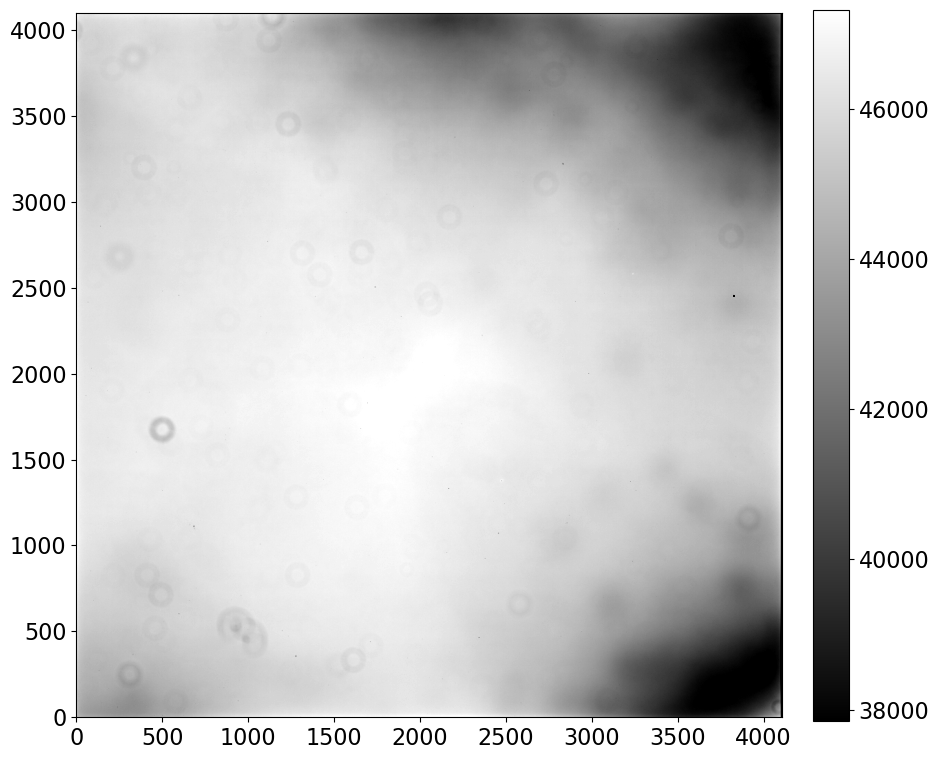

In [17]:
a_flat = CCDData.read(ifc_raw.files_filtered(imagetyp='flat', include_path=True)[0], unit='adu')

show_image(a_flat, cmap='gray')

There is a much different pattern of variation across the sensor in this case
than in Example 1. The multiple "donuts" in the image are pieces of dust and
there is significant vignetting (darkening) in the top and bottom corners of the
image on the right side.

### Subtract overscan and trim: only trim for this camera

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R511){:target="_blank"}

The overscan is not useful for this camera. The region to be retained after
trimming is the Python slice `[:, :4096]`.

Text(0.5, 1.0, 'Single flat frame, overscan trimmed')

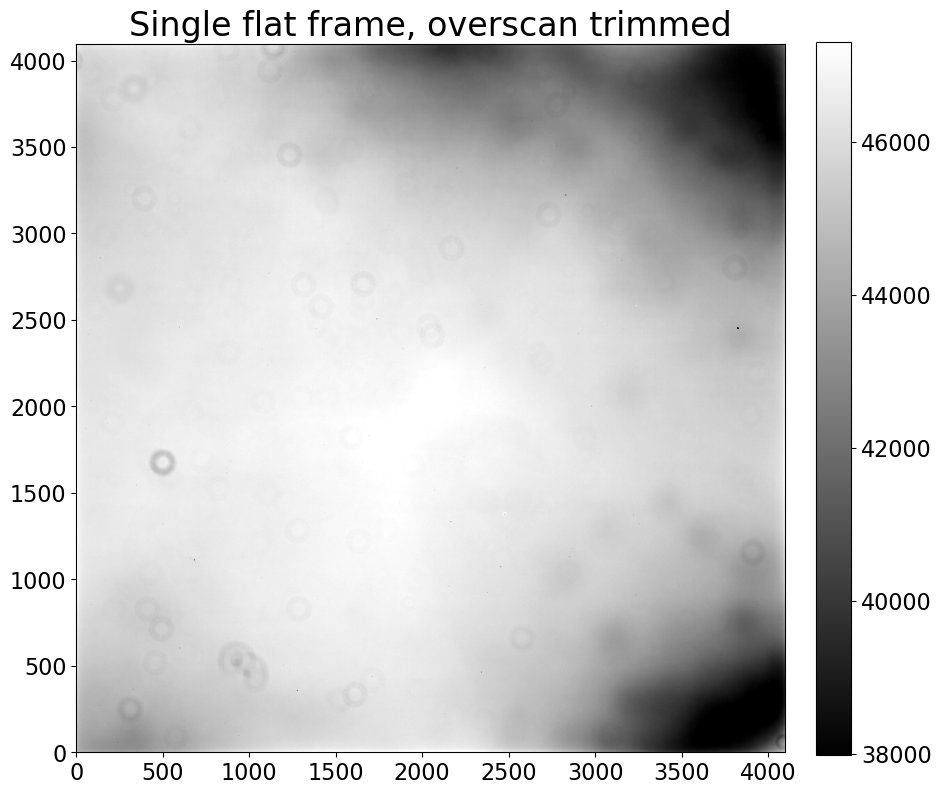

In [18]:
# Trim the overscan
a_flat_reduced = ccdp.trim_image(a_flat[:, :4096])

# Display the result so far
show_image(a_flat_reduced, cmap='gray')
plt.title('Single flat frame, overscan trimmed')

Trimming off the overscan did not make a big difference primarily because the
overscan region of this camera is not useful. A useful overscan would have had
values around the bias level for this camera, about 1200 counts. The image
stretch did change a bit; prior to trimming the lower end of the color scale was
38000 and now it is 40000.

### Subtracting bias is necessary

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R546){:target="_blank"}

For this particular set of images there is a combined dark with exposure time 90
sec. The flat images have the exposure times listed below:

In [19]:
set(ifc_raw.summary['exptime'][ifc_raw.summary['imagetyp'] == 'FLAT'])

{1.0, 1.02, 1.06, 1.11, 1.16, 1.21}

These are quite different than the exposure time of the dark frames, so the dark
will need to be scaled by exposure time, which means that the bias has been
removed from the combined dark.

Because of that, the bias needs to be removed from the flat before subtracting the
dark.

In [20]:
combined_bias = list(ifc_reduced.ccds(combined=True, imagetyp='bias'))[0]
a_flat_reduced = ccdp.subtract_bias(a_flat_reduced, combined_bias)

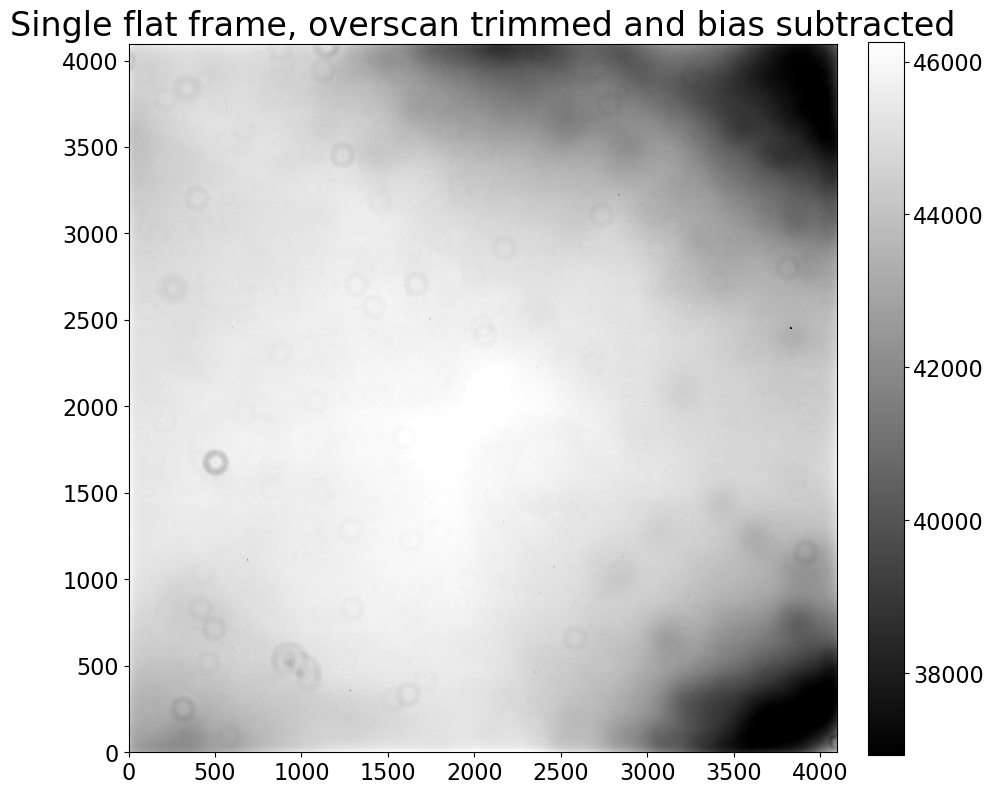

In [21]:
# Display the result so far
show_image(a_flat_reduced, cmap='gray')
plt.title('Single flat frame, overscan trimmed and bias subtracted');

Except for a change in the image scale shown on the color bar there isn't much
visually different after subtracting the bias.

### Subtract dark current, scaling as needed

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/211/files#diff-bd41f594acd69139c487547a641d2628R606){:target="_blank"}

Here we will need to scale the dark from the 90 sec exposure time of the dark
frame to the exposure time of each flat image. The [ccdproc function
`subtract_dark`](https://ccdproc.readthedocs.io/en/latest/api/ccdproc.subtract_dark.html#ccdproc.subtract_dark) provides keywords for doing this scaling automatically.

In [22]:
closest_dark = find_nearest_dark_exposure(a_flat_reduced, actual_exposure_times, tolerance=100)

It will be convenient to be able to access the darks via a dictionary whose key
is the exposure time, so we set that up below.

In [23]:
combined_darks = {ccd.header['exptime']: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}
combined_darks

{90.0: CCDData([[  6.8,  49.7,  39.4, ...,   5.6,   6. ,   1.9],
          [  3. ,  55.3,  33.3, ...,   7.9,  -3.3,   4.6],
          [ -2.4,  49.5,  36.5, ...,   8.4,   4.5,   8.7],
          ...,
          [  2.7,   5.9,   9.4, ...,  -1.8,   7.5,   2.7],
          [  0.4,  13.4,   7.4, ...,  -0.7,  12. ,  -3.3],
          [  0.1, -11.7,   3.1, ...,  -0.9,   2.6,   4.5]])}

Next, we subtract the dark from the flat and display the result.

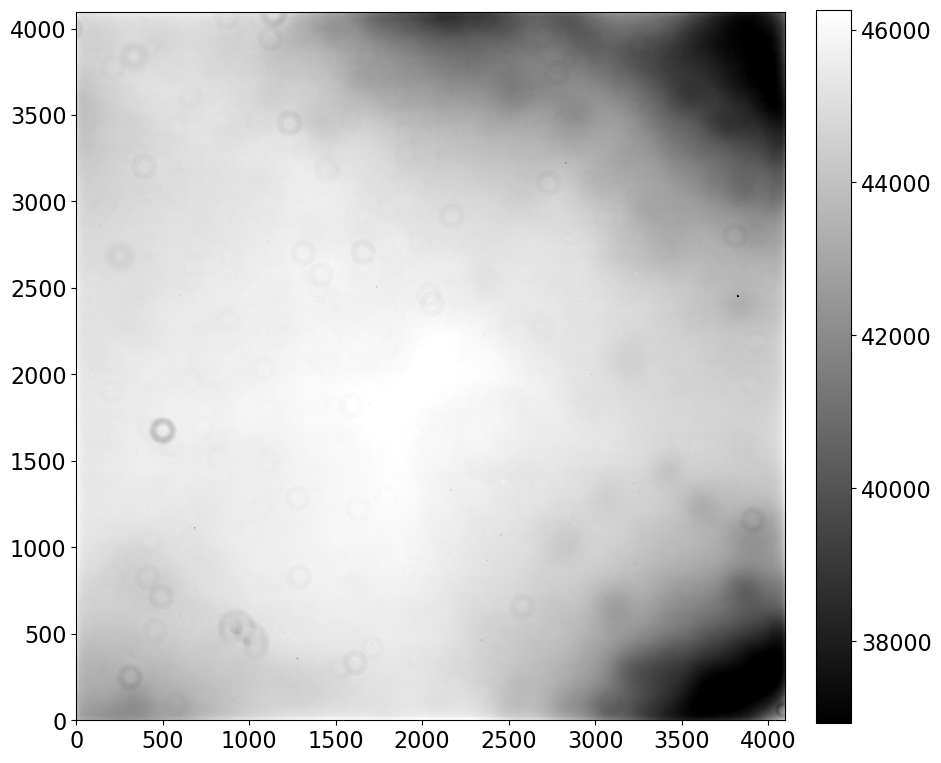

In [24]:
a_flat_reduced = ccdp.subtract_dark(a_flat_reduced, combined_darks[closest_dark], 
                                    exposure_time='exptime', exposure_unit=u.second, scale=True)
show_image(a_flat_reduced, cmap='gray')

There is not much change here; that is not surprising since the dark current in
this camera is low.

### Calibrate all of the flats in the folder

The cell below calibrates each of the flats in the folder, automatically
grabbing the correct combined dark for each flat.

In [25]:
for ccd, file_name in ifc_raw.ccds(imagetyp='FLAT',            # Just get the bias frames
                                   return_fname=True           # Provide the file name too.
                                  ):
        
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :4096])
    
    # Find the correct dark exposure
    closest_dark = find_nearest_dark_exposure(ccd, actual_exposure_times, tolerance=100)
    
    # Subtract the dark current 
    ccd = ccdp.subtract_dark(ccd, combined_darks[closest_dark],
                             exposure_time='exptime', exposure_unit=u.second, scale=True)

    # Save the result
    ccd.write(reduced_path / file_name)